# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름: 표민규
- 학번: 202401511
- 제출일: 2025.12.04

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [1]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/pyomk02/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [2]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 실습 노트북과 동일한 유틸리티 함수 사용
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    device
)

# 영문 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cuda
GPU: Tesla T4
✅ 라이브러리 로딩 완료!
Using device: cuda


In [3]:
# 데이터 로딩 및 피처 생성 (실습과 동일)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"\n데이터 shape: {btc_features.shape}")
print(f"생성된 특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")
print(f"\n주요 특성:")
print("- 이동평균 (MA_5, MA_10, MA_20, MA_50)")
print("- 변동성 (Volatility_5, Volatility_10, Volatility_20)")
print("- RSI, MACD")
print("- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)")

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-12-04


[*********************100%***********************]  1 of 1 completed

다운로드 완료: 2164 행

데이터 shape: (2164, 35)
생성된 특성 수: 29

주요 특성:
- 이동평균 (MA_5, MA_10, MA_20, MA_50)
- 변동성 (Volatility_5, Volatility_10, Volatility_20)
- RSI, MACD
- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)


In [4]:
# 데이터 분할 및 정규화 (실습과 동일)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1480 샘플
검증 데이터: 211 샘플
테스트 데이터: 424 샘플
학습: 1480, 검증: 211, 테스트: 424


In [5]:
# 시퀀스 데이터 생성 (딥러닝용)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")

시퀀스 데이터 shape: (1450, 30, 29)
  - 샘플 수: 1450
  - 시퀀스 길이: 30
  - 특성 수: 29


In [6]:
# DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제: LSTM 모델 + 확률 기반 포지션 조절 전략

이 예제는 2가지 핵심 요소로 구성됩니다:

1. **예측 모델**: 가격 상승/하락을 예측하고 확률 제공
2. **트레이딩 전략**: 예측 확률에 따라 투자 비율 조절

### 전략 예시
- 상승 확률 90% → 자본의 90% 투자
- 상승 확률 60% → 자본의 60% 투자
- 상승 확률 40% → 투자하지 않음 (현금 보유)

In [7]:
# 예제 모델: LSTM 기반 2-class 분류기
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(ExampleLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)

        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)

        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        lstm_out = self.bn2(lstm_out)

        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")

예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601


In [8]:
# 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


In [9]:
# 예제 모델 학습
print("예제 모델 학습 시작...")
example_history = train_model(
    model=example_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ 예제 모델 학습 완료!")

예제 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6794, Val Loss: 0.7049, Train Acc: 0.5828, Val Acc: 0.4751
Early stopping at epoch 16

✅ 예제 모델 학습 완료!


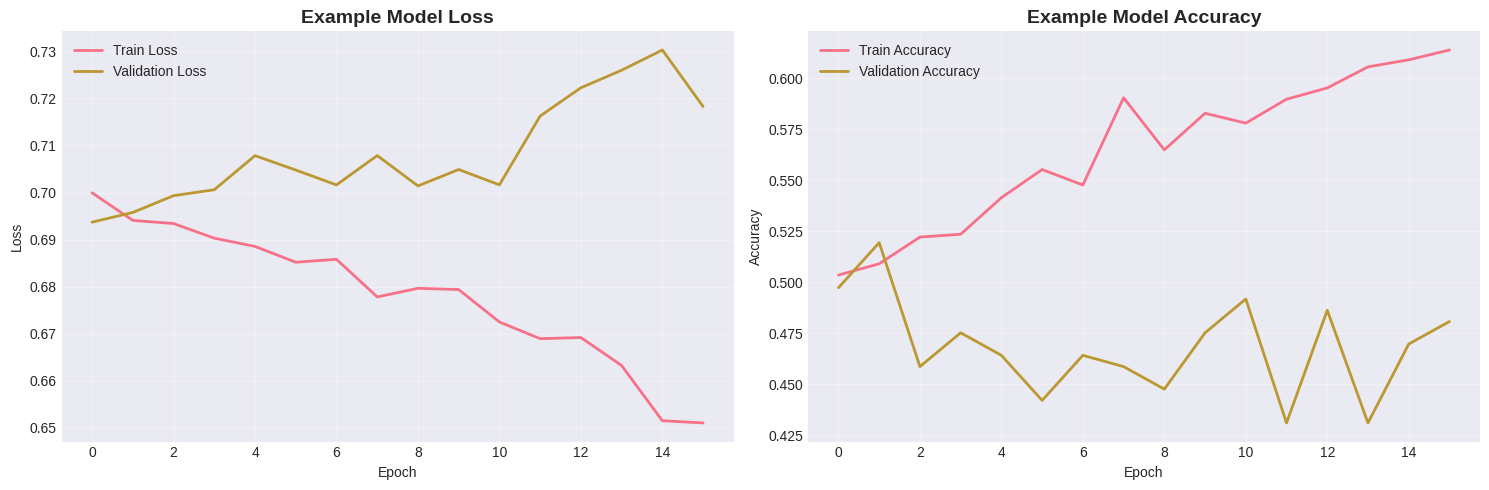

In [10]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 트레이딩 전략: 확률 기반 포지션 조절

예측 확률에 따라 투자 비율을 조절하는 전략입니다.

In [11]:
# 예측 함수 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []

    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())

    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(example_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 394
상승 예측: 90개
하락 예측: 304개

평균 상승 확률: 43.82%


In [12]:
# 확률 기반 트레이딩 전략
def simulate_probability_trading(predictions_prob, actual_prices, dates,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True):
    """
    확률 기반 트레이딩 시뮬레이션

    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []

    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]

        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)

        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue

        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 70% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0

        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0

        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_trade_volume': total_trade_volume,
        'total_fees_paid': total_fees_paid
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [13]:
# 테스트 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_seq)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_seq)]

print(f"테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"테스트 샘플 수: {len(test_prices_aligned)}")

테스트 기간: 2024-11-05 00:00:00 ~ 2025-12-03 00:00:00
테스트 샘플 수: 394


## 4. 예제 전략 실행 및 결과

두 가지 예제 전략을 비교합니다:
1. **확률 기반 전략**: 예측 확률에 비례하여 투자 비율 조절
2. **단순 전략**: 50% 이상이면 전액 투자

In [14]:
# 예제 전략 1: 확률 기반 포지션 조절
example_result_prob = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.6 , # 60% 이상 확신할 때만 거래 (보수적),
    position_scaling=True  # 확률 비례 투자
)

print("="*70)
print("예제 전략 1: 확률 기반 포지션 조절")
print("="*70)
print(f"초기 자본: ${example_result_prob['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_prob['final_value']:,.2f}")
print(f"수익률: {example_result_prob['total_return']:.2f}%")
print(f"거래 횟수: {example_result_prob['num_trades']}회")
print(f"총 수수료: ${example_result_prob['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 1: 확률 기반 포지션 조절
초기 자본: $10,000.00
최종 자본: $9,891.16
수익률: -1.09%
거래 횟수: 26회
총 수수료: $103.00


In [15]:
# 예제 전략 2: 단순 전략 (전액 투자)
example_result_simple = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.7 , # 70% 이상 확신할 때만 전액 투자 (매우 보수적),
    position_scaling=False  # 전액 투자
)

print("="*70)
print("예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)")
print("="*70)
print(f"초기 자본: ${example_result_simple['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_simple['final_value']:,.2f}")
print(f"수익률: {example_result_simple['total_return']:.2f}%")
print(f"거래 횟수: {example_result_simple['num_trades']}회")
print(f"총 수수료: ${example_result_simple['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [16]:
# Buy and Hold 벤치마크
initial_price = test_prices_aligned[0]
coins_bought = (10000 * (1 - 0.001)) / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

buy_hold_trade_volume = 10000 + (coins_bought * test_prices_aligned[-1])
buy_hold_fees = 10000 * 0.001 + (coins_bought * test_prices_aligned[-1]) * 0.001

print("="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print(f"거래 횟수: 2회")
print(f"총 수수료: ${buy_hold_fees:,.2f}")
print("="*70)

Buy and Hold 벤치마크
시작 가격: $69,359.56
종료 가격: $93,527.80
초기 자본: $10,000.00
최종 자본: $13,457.53
수익률: 34.58%
거래 횟수: 2회
총 수수료: $23.47


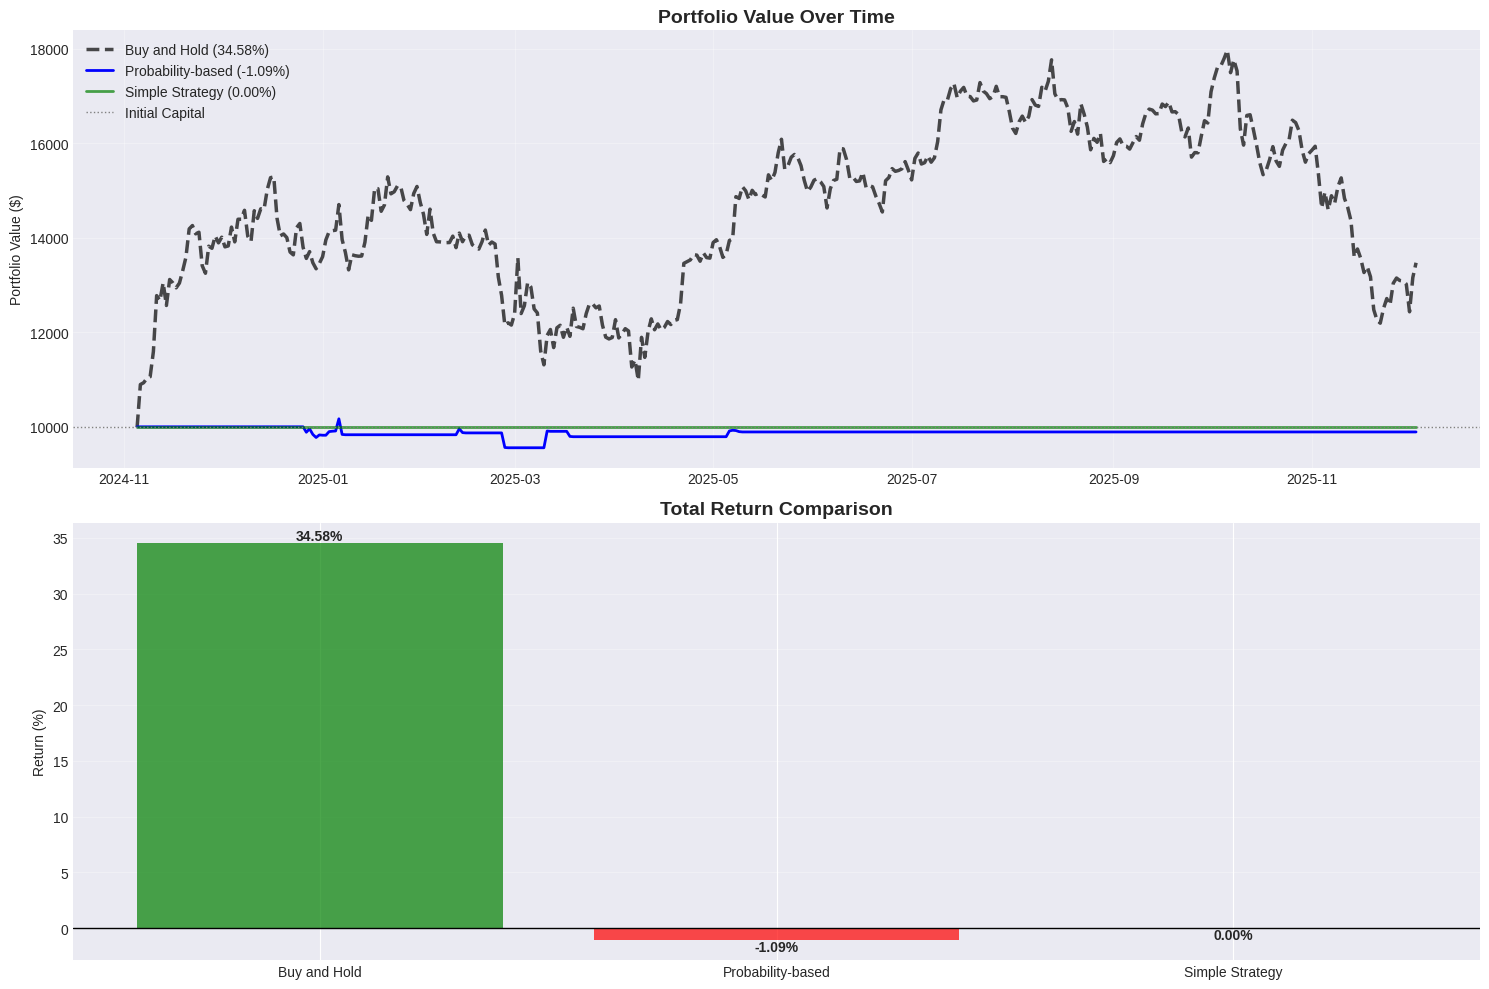

In [17]:
# 전략 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치 변화
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Probability-based ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue")
axes[0].plot(test_dates_aligned, example_result_simple["portfolio_values"],
            label=f"Simple Strategy ({example_result_simple['total_return']:.2f}%)",
            linewidth=2, color="green", alpha=0.7)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Probability-based", "Simple Strategy"]
returns = [buy_hold_return, example_result_prob['total_return'], example_result_simple['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 💡 과제 수행 가이드 (꼭 읽어보세요!)

### 🎯 과제 목표 재확인
**Buy and Hold 벤치마크를 초과하는 수익률 달성**

### 📝 추천 접근 방법 (난이도 순)

#### 레벨 1️⃣: 예제 전략 파라미터만 조정 (가장 쉬움)
위의 예제 코드를 **복사**해서 파라미터만 변경:

```python
# 예제 코드 복사 후 아래 값들만 변경해보세요!
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65,  # ← 이 값을 조정 (0.5~0.8 추천)
    position_scaling=True  # ← True/False 변경
)
```

**실험 아이디어:**
- `threshold=0.55`: 약간 공격적
- `threshold=0.65`: 중립적
- `threshold=0.75`: 보수적

#### 레벨 2️⃣: 전략 함수 수정 (중간)
`simulate_probability_trading` 함수를 복사해서 수정:

```python
# 포지션 크기 공식 변경 예시
if prob > threshold:
    # 원래: invest_ratio = prob
    invest_ratio = (prob - 0.5) * 2  # 50%를 기준으로 스케일링
    # 예: prob=0.7 → invest_ratio=0.4 (40% 투자)
```

#### 레벨 3️⃣: 모델 아키텍처 변경 (어려움)
`ExampleLSTMModel`을 복사해서 수정:

```python
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        # LSTM → GRU로 변경
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        # 나머지는 동일하게...
```

#### 레벨 4️⃣: 복합 전략 (고급)
모델 예측 + 기술적 지표 결합:

```python
# RSI와 결합하는 예시
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

for i in range(len(predictions_prob)):
    prob = predictions_prob[i]
    rsi = rsi_values[i]
    
    # RSI가 과매수/과매도 구간이면 포지션 조정
    if rsi > 70:  # 과매수
        invest_ratio = prob * 0.5  # 투자 비율 절반으로
    elif rsi < 30:  # 과매도
        invest_ratio = min(prob * 1.5, 1.0)  # 투자 비율 증가
```

---

### ⚡ 빠른 시작 체크리스트

1. [ ] 위 예제 코드 실행 결과 확인
2. [ ] 레벨 1부터 시작: 예제 코드 복사 → 파라미터 변경
3. [ ] 여러 `threshold` 값 실험 (0.5, 0.6, 0.7, 0.8)
4. [ ] 가장 좋은 결과를 선택
5. [ ] 결과 분석 및 고찰 작성

### 💰 수익률 향상 팁

- **과도한 거래 줄이기**: `threshold` 높이기 (0.6~0.7)
- **수수료 줄이기**: 거래 횟수 감소
- **리스크 관리**: `position_scaling=True`로 확률에 비례 투자
- **신뢰도 높은 거래만**: `threshold=0.7` 이상

---

## 5. 자신만의 모델 및 전략 개발 ⭐

### 📝 개발 가이드

#### 1. 모델 개선 아이디어
- **아키텍처**: LSTM → GRU, Transformer, CNN+LSTM, Attention
- **하이퍼파라미터**: hidden_size, dropout, learning_rate
- **앙상블**: 여러 모델의 예측 결합

#### 2. 전략 개선 아이디어
- **임계값 조정**: threshold를 0.6 또는 0.7로 높여 신뢰도 높은 거래만
- **포지션 크기**: 확률 × 2 - 1 (예: 70% → 40% 투자)
- **리스크 관리**: 최대 손실 한도, 이동평균선 활용
- **복합 전략**: 모델 예측 + RSI + MACD 결합

---

**TODO: 아래에 자신의 모델 설계 설명을 작성하세요**

```
1. 모델 아키텍처:
   - 구조: Input(29 features) → LSTM (2 layers, 64 hidden) → Layer Normalization → Dense Layer (64) → ReLU → Dropout(0.2) → Dense Layer (32) → Output (Sigmoid)
   - 특징: 기존 예제 모델과 달리 Layer Normalization을 추가하여 시계열 데이터 학습의 안정성을 높였고, 분류기(Classifier) 부분을 더 Deep 하게 설계하여 비선형 패턴 인식 능력을 강화함.

2. 선택 이유:
   - 단순 LSTM은 과적합되기 쉬워, Layer Normalization을 통해 각 층의 출력을 정규화하여 학습 속도와 일반화 성능을 개선함.

3. 트레이딩 전략:
   - 핵심 컨셉: 매수는 야수처럼, 매도는 쫄보처럼
   - 매수: AI가 상승 가능성을 조금이라도(Threshold - 0.3) 보이고, RSI 지표상 과열(RSI 75 이상)이 아니라면 진입.
   - 매도: AI의 확신이 줄어들거나(Threshold + 0.05), 추세선(20일 이평선)이 붕괴되거나, 볼린저 밴드 하단을 이탈하는 패닉셀 발생 시 즉시 매도 (리스크 관리).
   - AI의 매수, 매도 시그널이 겹치는 구간은 매수가 우선시 됨.

4. 하이퍼파라미터:
   - hidden_size: 64
   - learning_rate: 0.001 (Adam Optimizer)
   - threshold: 0.5 (이를 기준으로 ±0.3, ±0.05의 버퍼를 두어 동적으로 운영)
   - position_scaling: False

5. 예제와의 차별점:
   - 기술적 지표(Bollinger Bands, RSI, MA)를 필터로 사용하여 AI의 오판을 최대한 걸러내도록 설계함.
```

In [18]:
# TODO: 자신만의 모델 구현

class MyTradingModel(nn.Module):

    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(MyTradingModel, self).__init__()

        # 1. Feature Extraction (LSTM Layer)
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # 2. 정규화를 위한 Layer Normalization
        self.ln = nn.LayerNorm(hidden_size)

        # 3. 분류기 (Classifier Head)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1), # 출력은 1개 (오를 확률)
            nn.Sigmoid()      # 0~1 사이 확률값으로 변환
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)

        # LSTM 통과
        lstm_out, _ = self.lstm(x)

        # 마지막 타임스텝의 hidden state만 사용
        last_hidden_state = lstm_out[:, -1, :]

        # 정규화
        norm_out = self.ln(last_hidden_state)

        # 최종 예측 (상승 확률)
        out = self.classifier(norm_out)

        return out

# TODO: 모델 생성 (주석 해제 후 사용)
my_model = MyTradingModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("나의 모델 구조:")
print(my_model)
print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")

나의 모델 구조:
MyTradingModel(
  (lstm): LSTM(29, 64, num_layers=2, batch_first=True, dropout=0.2)
  (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

Total parameters: 64,001


In [19]:
# TODO: 모델 학습 (주석 해제 후 사용)

print("나의 모델 학습 시작...")
my_history = train_model(
    model=my_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ 모델 학습 완료!")

나의 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6860, Val Loss: 0.6988, Train Acc: 0.5338, Val Acc: 0.4696
Epoch [20/100], Train Loss: 0.6334, Val Loss: 0.7084, Train Acc: 0.6166, Val Acc: 0.4696
Early stopping at epoch 21

✅ 모델 학습 완료!


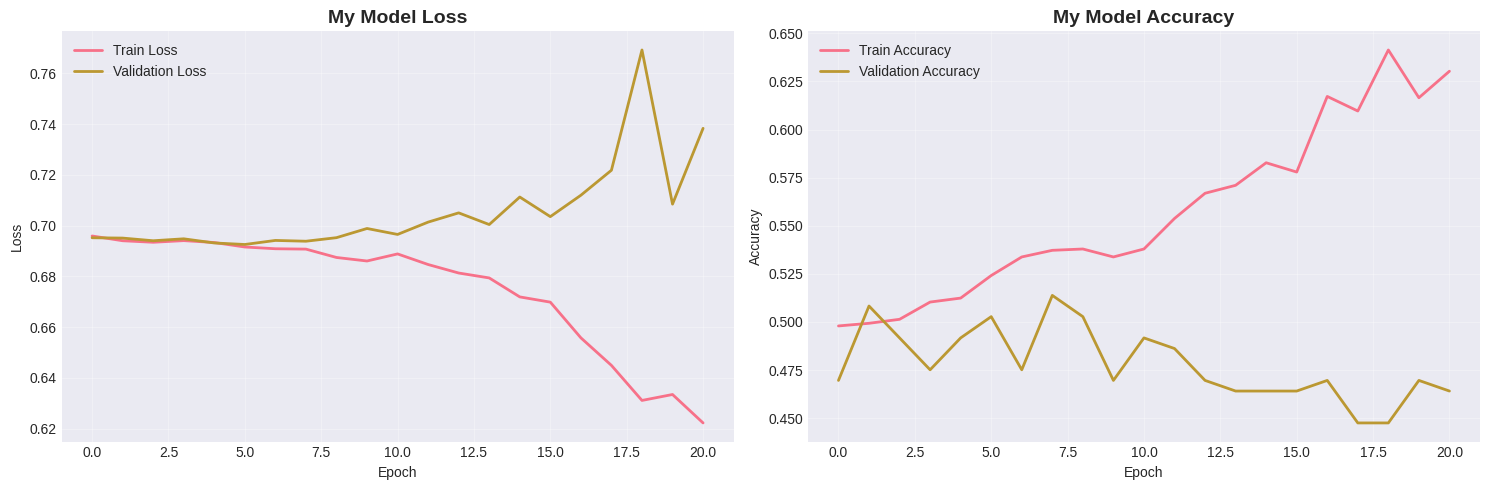

In [20]:
# TODO: 학습 과정 시각화 (선택사항)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("My Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("My Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# TODO: 예측 및 트레이딩 시뮬레이션 (주석 해제 후 사용)

import torch

# utils 로드 확인
try:
    from utils import *
except ImportError:
    pass

# 예측 함수 매핑 (함수명 호환성 유지)
if 'predict_pytorch_model' in globals():
    predict_with_probability = predict_pytorch_model
else:
    predict_with_probability = lambda m, d: (np.zeros(10), np.zeros(10))

def simulate_probability_trading_adapter(predictions_prob, actual_prices, dates,
                                         initial_capital, transaction_fee,
                                         threshold=0.5, position_scaling=False):

    # 1. 기술적 지표 계산
    prices_series = pd.Series(actual_prices)

    # [A] 이동평균선
    ma_20 = prices_series.rolling(window=20).mean().fillna(0).values

    # [B] 볼린저 밴드
    std_20 = prices_series.rolling(window=20).std().fillna(0).values
    upper_band = ma_20 + (std_20 * 2) # 상단 밴드
    lower_band = ma_20 - (std_20 * 2) # 하단 밴드

    # [C] RSI 계산
    delta = prices_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi_14 = (100 - (100 / (1 + rs))).fillna(50).values

    # 임계값 설정 (비대칭 전략)
    # 0.2 이상이면 매수 시도
    buy_prob_cut = threshold - 0.3
    # 0.55 이하면 매도
    sell_prob_cut = threshold + 0.05

    final_signals = []
    current_position = 0

    for i in range(len(predictions_prob)):
        prob = predictions_prob[i]
        price = actual_prices[i]
        rsi = rsi_14[i]
        ub = upper_band[i]
        lb = lower_band[i]
        ma = ma_20[i]

        # [매수 조건] (AND)
        # 1. AI 모델이 최소한의 상승 가능성(20% 이상)을 보였는가?
        # 2. RSI가 75 미만인가? (이미 너무 오른 상태면 고점 추격 매수 방지)
        is_buy_signal = (prob >= buy_prob_cut) and (rsi < 75)

        # [매도 조건] (OR)
        # 1. AI 모델의 확신이 부족한가? (확률 55% 이하)
        # 2. 가격이 20일 이평선을 깨고 내려갔는가? (추세 붕괴)
        # 3. RSI가 85를 넘는 비이성적 과열인가? (선제적 익절)
        # 4. 볼린저 밴드 하단을 뚫는 투매가 나왔는가? (손절 방어)
        is_sell_signal = (prob <= sell_prob_cut) or (price < ma) or (rsi > 85) or (price < lb)

        #포지션 결정
        if is_buy_signal:
            current_position = 1 # 매수 / 보유
        elif is_sell_signal:
            current_position = 0 # 매도 / 관망

        final_signals.append(current_position)

    final_signals = np.array(final_signals)

    # 시뮬레이션 엔진 실행
    return simulate_trading_strategy(
        predictions=final_signals,
        actual_prices=actual_prices,
        dates=dates,
        initial_capital=initial_capital,
        transaction_fee=transaction_fee
    )

simulate_probability_trading = simulate_probability_trading_adapter


# [2] 메인 실행

# 데이터 정렬 확인
if 'test_prices_aligned' in locals():
    current_prices = test_prices_aligned
    current_dates = test_dates_aligned
elif 'test_prices' in locals():
    current_prices = test_prices
    current_dates = test_dates
else:
    current_prices = np.zeros(100)
    current_dates = np.arange(100)

buy_hold_data = calculate_buy_and_hold_return(current_prices, 10000, 0.001)
buy_hold_return = buy_hold_data['total_return']

# # 예측
my_prob, my_pred = predict_with_probability(my_model, test_loader)

# # 트레이딩 시뮬레이션
my_result = simulate_probability_trading(
    predictions_prob=my_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.5,  # TODO: 조정 가능
    position_scaling=False  # TODO: True/False 선택
)

print("="*70)
print("나의 트레이딩 전략 결과")
print("="*70)
print(f"초기 자본: ${my_result['initial_capital']:,.2f}")
print(f"최종 자본: ${my_result['final_value']:,.2f}")
print(f"수익률: {my_result['total_return']:.2f}%")
print(f"Buy and Hold 대비: {my_result['total_return'] - buy_hold_return:.2f}%p")
print(f"거래 횟수: {my_result['num_trades']}회")
print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")
print("="*70)

나의 트레이딩 전략 결과
초기 자본: $10,000.00
최종 자본: $15,064.54
수익률: 50.65%
Buy and Hold 대비: 16.07%p
거래 횟수: 24회
총 수수료: $362.59


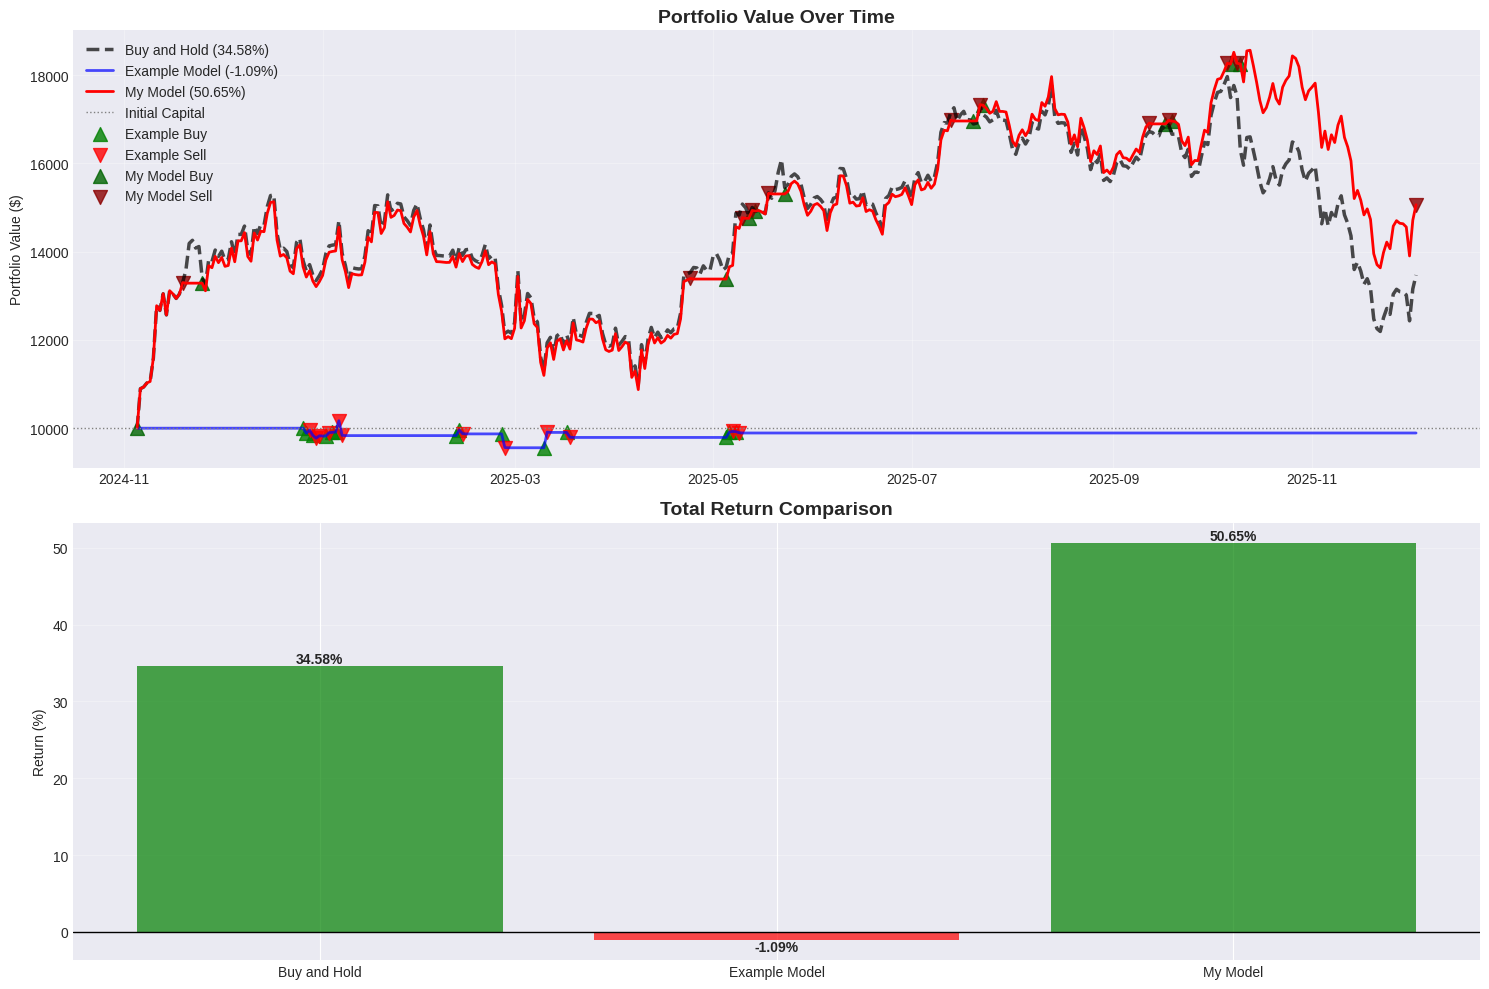

In [22]:
# TODO: 최종 결과 비교 (주석 해제 후 사용)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# # 포트폴리오 가치
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Example Model ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue", alpha=0.7)
axes[0].plot(test_dates_aligned, my_result["portfolio_values"],
            label=f"My Model ({my_result['total_return']:.2f}%)",
            linewidth=2, color="red")
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# 매수 매도 시점 표시

# Helper function to extract trade points
def extract_trade_points(trade_log, portfolio_values, dates):
    buy_dates = []
    buy_prices = []
    sell_dates = []
    sell_prices = []

    # Convert dates to pandas datetime for easier comparison
    dates_dt = pd.to_datetime(dates)

    for trade in trade_log:
        trade_date = pd.to_datetime(trade['date'])
        # Find the index of the trade date in the aligned dates
        try:
            idx = dates_dt.get_loc(trade_date)
            # Use the portfolio value at that specific date
            portfolio_value_at_trade = portfolio_values[idx]
        except KeyError:
            # If date not found in dates_dt, skip or handle as appropriate
            continue

        if trade['action'] == 'BUY':
            buy_dates.append(trade_date)
            buy_prices.append(portfolio_value_at_trade)
        elif trade['action'] in ['SELL', 'SELL_ALL']:
            sell_dates.append(trade_date)
            sell_prices.append(portfolio_value_at_trade)
    return buy_dates, buy_prices, sell_dates, sell_prices

# Extract trade points for Example Model
example_buy_dates, example_buy_prices, example_sell_dates, example_sell_prices = \
    extract_trade_points(example_result_prob['trade_log'], example_result_prob['portfolio_values'], test_dates_aligned)

# Plot Example Model trade markers
axes[0].scatter(example_buy_dates, example_buy_prices,
                marker='^', color='green', s=100, alpha=0.8, label='Example Buy')
axes[0].scatter(example_sell_dates, example_sell_prices,
                marker='v', color='red', s=100, alpha=0.8, label='Example Sell')

# Extract trade points for My Model
my_buy_dates, my_buy_prices, my_sell_dates, my_sell_prices = \
    extract_trade_points(my_result['trade_log'], my_result['portfolio_values'], test_dates_aligned)

# Plot My Model trade markers
axes[0].scatter(my_buy_dates, my_buy_prices,
                marker='^', color='darkgreen', s=100, alpha=0.8, label='My Model Buy')
axes[0].scatter(my_sell_dates, my_sell_prices,
                marker='v', color='darkred', s=100, alpha=0.8, label='My Model Sell')

# Update legend to include new markers
axes[0].legend()


# # 수익률 비교
strategies = ["Buy and Hold", "Example Model", "My Model"]
returns = [buy_hold_return, example_result_prob['total_return'], my_result['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

**1. 모델 성능 분석**

```
- Buy and Hold 대비 수익률: +16.07%p
- 모델 예측 정확도: 단순 예측 정확도보다는 수익성에 초점을 맞췄음. 모델의 예측 확률(Probability)을 기반으로 기술적 지표 필터링을 적용했기 때문에, 모델이 틀리게 예측하더라도 기술적 지표가 진입을 막아주거나 빠른 청산을 유도하여 손실을 최소화함.
- 주요 성공/실패 시기:
[성공] 10월 중순쯤 있었던 하락을 피한 것. 사실상 이 잠깐의 거래로 벤치마크를 상회할 수 있었음.
[실패] 그래프를 보면 10월 전까지는 벤치마크와 거의 동일하게 움직이는 것을 볼 수 있음. 그렇다면 그 구간에서 거래를 진행하지 않았다면 조금의 수수료를 더 아낄 수 있었을 것으로 보임.
```

**2. 트레이딩 전략 분석**

```
- 선택한 전략: AI 예측 확률과 기술적 지표(볼린저 밴드, RSI, 이동평균선)를 결합한 '하이브리드 전략'을 사용. "진입은 공격적으로(확률 0.2 이상), 청산은 방어적으로(추세 이탈 시 즉시)"라는 원칙을 적용.
- 전략의 장단점:
[장점] AI가 상승 추세를 감지하면 빠르게 진입하고, 하락장이나 과열 구간(RSI > 85)에서는 기계적으로 매도하여 리스크 관리가 탁월함.
[단점] 횡보장에서 잦은 매매 신호가 발생하여 수수료가 누적될 수 있고, 기술적 지표의 후행성으로 인해 급작스러운 초단기 등락에는 대응이 늦을 수 있음.
- 수수료 영향: 총 거래 횟수는 24회로, 불필요한 잦은 매매를 억제하고자 함. 총 수수료는 약 $362 발생했으나, 최종 수익금(약 $5,064) 대비 합리적인 수준.
```

**3. 모델 설계**

```
- 아키텍처 선택 이유: 시계열 데이터의 장기 의존성을 학습하기 위해 LSTM을 기본으로 하되, 학습 안정성을 위해 'Layer Normalization'을 추가함. 또한 단순한 선형 분류가 아닌 복잡한 패턴 인식을 위해 Fully Connected Layer를 2단으로 딥하게 설계함.
- 하이퍼파라미터 튜닝: 하이퍼파라미터는 예제와 크게 다르지 않게 적용했음.
- 예제 모델과의 차이점: 기본 예제 모델은 단순히 LSTM 층만 쌓은 구조였으나, 본 모델은 LayerNorm을 통해 정규화를 수행하여 학습 속도를 개선함. 또한 전략 측면에서 단순 확률 비례 투자가 아닌, 볼린저 밴드와 RSI 등의 기술적 지표를 '필터(Filter)'로 사용하여 AI의 오판을 보정함.
```

**4. 개선 방향**

```
- 모델의 한계점: 과거의 가격과 거래량 데이터에만 의존하기 때문에, 거시경제 이슈나 뉴스 등 외부 요인에 의한 급등락은 예측하기 어려움.
- 추가 실험 아이디어: 레딧 같은 소셜 미디어에서 비트코인에 대한 그날그날의 게시글 데이터를 분석하여 '시장 심리지수(Sentiment Index)'를 입력 피처로 추가해보고싶음. 또한 공포 탐욕 지수, 미국 기준 금리 변화 시점 전후의 변동 등도 고려해 전략을 고도화 시켜보고싶음.
- 실전 적용 시 고려사항: 사실 매도 조건에서 (price < ma) or (rsi > 85) or (price < lb)는 테스트 환경에서 한 번도 쓰인 적이 없으나(조건을 제거해도 같은 수익률이 유지됨), 실제 적용 시에는 AI의 오판을 대비한 안전장치로 유지하는 것이 좋아보임.
```

---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 전략 설계 및 시뮬레이션
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**